# Validación del Modelo de Regresión Logística

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)


In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
from pyspark.ml.feature import VectorAssembler

bd5 = bd5.withColumn('Horario1',(bd5.Horario==1) 
).withColumn('Horario2',(bd5.Horario==2) 
).withColumn('Horario3',(bd5.Horario==3))

# Términos cuadráticos añadidos manualmente
bd5 = bd5.withColumn('DepDelay2',(bd5.DEP_DELAY**2)
).withColumn('DepD_Distance',(bd5.DEP_DELAY * bd5.DISTANCE)) 

Configuración de la Base de Datos

In [4]:
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DEP_DELAY','DISTANCE','DAY_OF_WEEK',
               'CRS_DEP_TIME','Horario1','Horario2',
               'Horario3','DepDelay2','DepD_Distance'],
    outputCol='features')

bd6 = a1.transform(bd5).select(col("Retraso").cast('double').alias("label"),'features')

## Ajuste del modelo

In [5]:
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     threshold=0.5)
                        
model = lgr.fit(bd6)

In [6]:
print(model.intercept,model.coefficients)

-1.6228762950365914 [0.0174818630425,-0.000153907645432,0.00622037724017,0.000243814478493,-0.18527035429,0.0280656797874,0.0553254124157,1.4042617353e-06,9.64852764749e-06]


In [7]:
pred = model.transform(bd6)



/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [8]:
pred.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[-8.0,236.0,4.0,1...|[1.38588018074077...|[0.79993372290508...|       0.0|
|  0.0|[6.0,236.0,4.0,12...|[1.15805757782493...|[0.76097958746655...|       0.0|
|  0.0|[-5.0,236.0,4.0,1...|[1.45534475592752...|[0.81081963453715...|       0.0|
|  0.0|[-6.0,236.0,4.0,8...|[1.52482637822825...|[0.82124809014486...|       0.0|
|  0.0|[-5.0,651.0,4.0,2...|[1.48413341690803...|[0.81519609728737...|       0.0|
|  0.0|[-5.0,370.0,4.0,1...|[1.36274699976021...|[0.79620579443903...|       0.0|
|  0.0|[-8.0,868.0,4.0,1...|[1.46071846651767...|[0.81164253777179...|       0.0|
|  0.0|[-6.0,1464.0,4.0,...|[1.77760088417091...|[0.85540037083745...|       0.0|
|  0.0|[-3.0,1464.0,4.0,...|[1.61064779104856...|[0.83350130426781...|       0.0|
|  0.0|[-6.0,105

Los valores de *probability* son transformados a *prediction* empleando un punto de corte. 

Por defecto: 0.5

## Confussion Matrix

In [9]:
pred.count()

30466

In [10]:
cm = pred.groupBy('label','prediction').count().sort('label','prediction')
cm.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|22056|
|  0.0|       1.0|    9|
|  1.0|       0.0| 5119|
|  1.0|       1.0| 3282|
+-----+----------+-----+



In [11]:
TN = cm.filter((cm.label == 0) & (cm.prediction == 0)).collect()[0][2]
FP = cm.filter((cm.label == 0) & (cm.prediction == 1)).collect()[0][2]
FN = cm.filter((cm.label == 1) & (cm.prediction == 0)).collect()[0][2]
TP = cm.filter((cm.label == 1) & (cm.prediction == 1)).collect()[0][2]

N=TN+FP+TP+FN

Prev = (TP + FN) / N  
Sens = TPR = Recall = TP / (TP + FN) 
Esp  = TN / (TN + FP) #= (1 - FPR)
Precision = PPV = TP / (TP + FP) 
Acc = (TP+TN) / N

print('Prev=',Prev)
print('Sens=',Sens)
print('Esp=',Esp)
print('Recall=',Recall)
print('Precision=',Precision)
print('Acc=',Acc)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator as MCE
print('Acc=',MCE(metricName="weightedRecall").evaluate(pred))

Prev= 0.2757500164117377
Sens= 0.3906677776455184
Esp= 0.9995921142080217
Recall= 0.3906677776455184
Precision= 0.9972652689152234
Acc= 0.8316812184074049
Acc= 0.8316812184074049


## Modificacion del Punto de Corte

In [12]:
lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",                         
     threshold=0.27)
#threshold=Prev

model = lgr.fit(bd6)
pred = model.transform(bd6)


cm = pred.groupBy('label','prediction').count().sort('label','prediction')
cm.show()

print('Acc=',MCE(metricName="weightedRecall").evaluate(pred))

/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|20464|
|  0.0|       1.0| 1601|
|  1.0|       0.0| 1803|
|  1.0|       1.0| 6598|
+-----+----------+-----+

Acc= 0.8882688899100637


## Curva ROC

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))

pred2.show(10)

+-----+--------------------+--------------------+--------------------+----------+----------+
|label|            features|       rawPrediction|         probability|prediction|     probs|
+-----+--------------------+--------------------+--------------------+----------+----------+
|  0.0|[-8.0,236.0,4.0,1...|[1.38588018074077...|[0.79993372290508...|       0.0|0.20006628|
|  0.0|[6.0,236.0,4.0,12...|[1.15805757782493...|[0.76097958746655...|       0.0| 0.2390204|
|  0.0|[-5.0,236.0,4.0,1...|[1.45534475592752...|[0.81081963453715...|       0.0|0.18918036|
|  0.0|[-6.0,236.0,4.0,8...|[1.52482637822825...|[0.82124809014486...|       0.0|0.17875192|
|  0.0|[-5.0,651.0,4.0,2...|[1.48413341690803...|[0.81519609728737...|       0.0| 0.1848039|
|  0.0|[-5.0,370.0,4.0,1...|[1.36274699976021...|[0.79620579443903...|       0.0|0.20379421|
|  0.0|[-8.0,868.0,4.0,1...|[1.46071846651767...|[0.81164253777179...|       0.0|0.18835746|
|  0.0|[-6.0,1464.0,4.0,...|[1.77760088417091...|[0.85540037083745...|

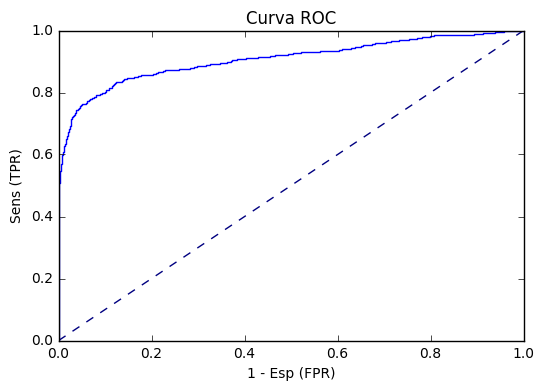

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import seaborn as sns

pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()

fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

## Área Bajo la Curva ROC

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))
print('AUC=',BCE(metricName="areaUnderROC").evaluate(pred))

AUC= 0.9053308831809359
AUC= 0.9053308831809805


In [16]:
#LogisticRegression(maxIter=10, 
#     labelCol="label", 
#     featuresCol="features",
#     predictionCol="prediction", 
#     regParam=0.1, 
#     elasticNetParam=0.0, 
#     fitIntercept=True, 
#     threshold=0.5, 
#     probabilityCol="probability", 
#     rawPredictionCol="rawPrediction", 
#     standardization=True, 
#     weightCol=None)